In [38]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from IPython import display
import seaborn
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD


%matplotlib inline
seaborn.set()

class Catch(object):
    """
    Class catch is the actual game.
    """
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas
        
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]

        
last_frame_time = 0
translate_action = ["Left","Stay","Right","Create Ball","End Test"]
grid_size = 10

def display_screen(action,points,input_t,counter):
    global last_frame_time
    print("Action %s, Points: %d" % (translate_action[action],points))
    #Only display the game screen if the game is not over
    if("End" not in translate_action[action]):
        #Render the game with matplotlib
        plt.imshow(input_t.reshape((grid_size,)*2), interpolation='none', cmap='gray')
        plt.savefig('./frame'+str(counter)+'.png')
        #Clear whatever we rendered before
#         display.clear_output(wait=True)
        #And display the rendering
#         display.display(plt.gcf())
    #Update the last frame time
    last_frame_time = set_max_fps(last_frame_time)
    
    
def set_max_fps(last_frame_time,FPS = 16):
    current_milli_time = lambda: int(round(time.time() * 1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    sleep_time = 1./FPS
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()




In [28]:
import numpy as np
import scipy
import random

import os
import keras
import tensorflow as tf
from keras.models import Sequential,load_model, Model
from keras.layers import Dense, Dropout, Flatten, Multiply
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.optimizers import Adam, Adamax, RMSprop
from keras import backend as K

MAX_TIMESTEP = 1000
MAX_EP = 100000
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

random.seed(2)
np.random.seed(2)
tf.set_random_seed(2)

def categorical_crossentropy(target, output):
    _epsilon =  tf.convert_to_tensor(10e-8, dtype=output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    return (- target * tf.log(output))


class Agent_ActorCritic():
    def __init__(self, env):
        self.log_path = './actor_critic.log'

        self.env = env
        self.actions_avialbe = 3
        self.feature_dim = 100
        self.t = 0
        self.prev_x = None
        self.actor_learning_rate  = 1e-3
        self.critic_learning_rate = 1e-3
        self.gamma = 0.9
        self.dummy_act_picked = np.zeros((1,self.actions_avialbe))
        self.episode_number_list = []
        self.average_reward_list = []
        self.entropy_list = []
        
        # Actor
        input_frame  = Input(shape=(self.feature_dim,))
        act_picked = Input(shape=(self.actions_avialbe,))
        hidden_f = Dense(20,activation='relu')(input_frame)

        act_prob = Dense(self.actions_avialbe,activation='softmax')(hidden_f)
        selected_act_prob = Multiply()([act_prob,act_picked])
        selected_act_prob = Lambda(lambda x:K.sum(x, axis=-1, keepdims=True),output_shape=(1,))(selected_act_prob)

        model = Model(inputs=[input_frame,act_picked], outputs=[act_prob, selected_act_prob])

        opt = Adam(lr=self.actor_learning_rate)
        model.compile(loss=['mse',categorical_crossentropy], loss_weights=[0.0,1.0],optimizer=opt)
        self.actor = model

        # Critic
        model = Sequential()
        model.add(Dense(20,activation='relu',input_shape=(self.feature_dim,)))
        model.add(Dense(1))

        opt = Adam(lr=self.critic_learning_rate)
        model.compile(loss='mse', optimizer=opt)
        self.critic = model

    def init_game_setting(self):
        self.prev_x = None


    def train(self):
        # Init
        log = open(self.log_path,'w')
        batch_size = 1 
        frames, prob_actions, dlogps, drs =[], [], [], []
        tr_x, tr_y = [],[]
        reward_record = []
        avg_reward = []
        avg_entropy = []
        reward_sum = 0
        ep_number = 0
        ep_step = 0 
        self.env.reset()
        observation = self.env.observe()
        maxs = 0
        entropy_per_episode = 0
        while True:
            
#             temp_p = self.actor.predict([observation,self.dummy_act_picked])[0].flatten()
            temp_p = self.actor.predict([observation,self.dummy_act_picked])
            
            entropy = -np.sum(temp_p[0][0] * np.log(temp_p[0][0]))
            entropy_per_episode = entropy_per_episode + entropy
            act = np.random.choice(np.arange(self.actions_avialbe), 
                    p=temp_p[0][0])

            act_one_hot = np.zeros((1,self.actions_avialbe))
            act_one_hot[0,act]=1.0
            next_observation, reward, done = self.env.act(act)
            #if done: reward = -20
            
            reward_sum += reward
            predict_reward = self.critic.predict(observation)
            predict_next_reward = self.critic.predict(next_observation)

            td_target = np.expand_dims(reward,axis=0) + self.gamma*predict_next_reward 
            td_error = td_target - predict_reward + 0.01*entropy

            self.critic.train_on_batch(observation,td_target)
            self.actor.train_on_batch([observation,act_one_hot],[self.dummy_act_picked,td_error])

            observation = next_observation

            self.t += 1
            ep_step += 1

            if done or ep_step>MAX_TIMESTEP:
                ep_number += 1
                entropy_per_episode = entropy_per_episode/ep_step
                avg_entropy.append(entropy_per_episode)
                avg_reward.append(float(reward_sum))
                if len(avg_reward)>300: avg_reward.pop(0)
                if len(avg_entropy)>300: avg_entropy.pop(0)
                mean_entropy = np.mean(avg_entropy)
                mean_reward = np.mean(avg_reward)
                self.entropy_list.append(mean_entropy)
                print('EPISODE: {0:6d} / TIMESTEP: {1:8d} / REWARD: {2:5d} / AVG_REWARD: {3:2.3f} '.format(
                            ep_number, self.t, int(reward_sum), mean_reward),mean_entropy)
#                 print('{:.4f},{:.4f}'.format(reward_sum,np.mean(avg_reward)),end='\n',file=log,flush=True)
                entropy_per_episode = 0
                self.env.reset()
                observation = self.env.observe()
                reward_sum = 0.0
                ep_step = 0
                self.episode_number_list.append(ep_number)
                self.average_reward_list.append(mean_reward)
                log.write(str(ep_number)+" "+str(mean_reward))
                if (maxs < mean_reward or mean_reward==1)  and (ep_number > 300):
                    maxs = mean_reward
                    print("saved model maxs:", maxs, "caught fruits (300): ",(300*maxs+300)/2)
                    if (maxs >= 0.90 or (maxs<0.6 and maxs > 0.58) or (maxs<0.2 and maxs > 0.18)):
                        name_actor = "actor"+str(maxs)+".h5"
                        name_critic = "critic"+str(maxs)+".h5"
                        self.actor.save(name_actor)
                        self.critic.save(name_critic)
                        if (maxs>= 0.90):
                            plt.figure(1)
                            plt.plot(self.episode_number_list,self.average_reward_list)
                            plt.xlabel('episodes')
                            plt.ylabel('average reward')
                            plt.savefig('./learning_curve.png')
                            plt.show()
                            plt.figure(2)
                            plt.plot(self.episode_number_list,self.entropy_list)
                            plt.xlabel('episodes')
                            plt.ylabel('entropy')
                            plt.savefig('./entropy_curve.png')
                            plt.show()
                            break
                    




In [32]:
agent = Agent_ActorCritic(Catch(10))
agent.train()
# plt.figure(1)
# plt.plot(agent.episode_number_list,agent.average_reward_list)
# plt.xlabel('episodes')
# plt.ylabel('average reward')
# plt.savefig('./learning_curve.png')
# plt.show()
# plt.figure(2)
# plt.plot(agent.episode_number_list,agent.entropy_list)
# plt.xlabel('episodes')
# plt.ylabel('entropy')
# plt.savefig('./entropy_curve.png')
# plt.show()


EPISODE:      1 / TIMESTEP:        9 / REWARD:    -1 / AVG_REWARD: -1.000  1.09173760149214
EPISODE:      2 / TIMESTEP:       18 / REWARD:    -1 / AVG_REWARD: -1.000  1.090909163157145
EPISODE:      3 / TIMESTEP:       27 / REWARD:    -1 / AVG_REWARD: -1.000  1.0914982733903107
EPISODE:      4 / TIMESTEP:       36 / REWARD:    -1 / AVG_REWARD: -1.000  1.0893589655558267
EPISODE:      5 / TIMESTEP:       45 / REWARD:    -1 / AVG_REWARD: -1.000  1.0887049595514933
EPISODE:      6 / TIMESTEP:       54 / REWARD:    -1 / AVG_REWARD: -1.000  1.0867860361381814
EPISODE:      7 / TIMESTEP:       63 / REWARD:    -1 / AVG_REWARD: -1.000  1.0871080576427399
EPISODE:      8 / TIMESTEP:       72 / REWARD:     1 / AVG_REWARD: -0.750  1.0865150690078735
EPISODE:      9 / TIMESTEP:       81 / REWARD:    -1 / AVG_REWARD: -0.778  1.0854238360016435
EPISODE:     10 / TIMESTEP:       90 / REWARD:    -1 / AVG_REWARD: -0.800  1.0863422526253594
EPISODE:     11 / TIMESTEP:       99 / REWARD:    -1 / AVG_REWA

KeyboardInterrupt: 

Action Left, Points: 0
Action Left, Points: 0
Action Left, Points: 0
Action Left, Points: 0
Action Stay, Points: 0
Action Left, Points: 0
Action Right, Points: 0
Action Stay, Points: 0
Action Stay, Points: -1
Action Left, Points: -1
Action Stay, Points: -1
Action Stay, Points: -1
Action Stay, Points: -1
Action Stay, Points: -1
Action Stay, Points: -1
Action Stay, Points: -1
Action Stay, Points: -1
Action Stay, Points: -2
Action Left, Points: -2
Action Left, Points: -2
Action Right, Points: -2
Action Right, Points: -2
Action Stay, Points: -2
Action Stay, Points: -2
Action Stay, Points: -2
Action Stay, Points: -2
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -3
Action Stay, Points: -2
Action Left, Points: -2
Action Left, Points: -2
Action Left, Points: -2
Action Left, Points: -2
Action Left, Points: -2
Action Left, Points: 

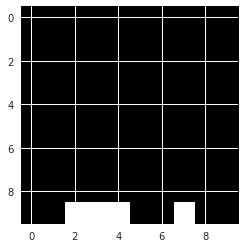

In [48]:
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2

env = Catch(10)
actor = load_model('actor.h5')
# critic =  load_model('critictor.h5')
score = 0
average_value_fn = 0
counter = 0

for e in range(30):
    done = False
    env.reset()
    state = env.observe()
    state = np.reshape(state, [1, 100])
#     print(str(e)+" "+str(score))
    dummy_act_picked=np.zeros((1,3))
    while not done:

        counter = counter + 1
        temp_p = actor.predict([state,dummy_act_picked])
        act = np.argmax(temp_p[0][0])
#         print(act_one_hot)
        act_one_hot = np.zeros((1,3))
        act_one_hot[0,act]=1.0
        dummy_act_picked = act_one_hot
        next_state, reward, done = env.act(act)
        next_state = np.reshape(next_state, [1, 100])
        average_value_fn = average_value_fn + critic.predict(state) 
        score = score + reward
        display_screen(act,score,next_state, counter)
#         print(state.reshape(10,10))
        #plt.imshow(next_state.reshape(10,10))
    
        #Clear whatever we rendered before
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
#         plt.show()
        state = next_state
#plt.show()        
print('average value fn:', average_value_fn/(5000))        